# Machine Learning for Data Analysis
# Assignment: Running a k-Means Cluster Analysis

Following is the Python program I wrote to fulfill the last assignment of the [Machine Learning for Data Analysis online course](https://www.coursera.org/learn/machine-learning-data-analysis/home/welcome).

I decided to use [Jupyter Notebook](http://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/Notebook/Index.ipynb) as it is a pretty way to write code and present results.

## Assignment research question

I decided to use the same research question than for the previous assignment on [Lasso regression](LassoRegression.ipynb) analysis.

Using the [Gapminder database](http://www.gapminder.org/), I would like to see the variables that are the most influencing income per person (2010 GDP per capita in constant 2000 US$). It will therefore be my test variable.

The cluster analysis will be carried out on the following variables:
- Residential electricity consumption (per person in kWh)
- CO2 emissions (in metric tons)
- Employment rate (total employees age 15+ in % of the population)
- Internet use rate (Internet users per 100 people)
- Life expectancy (Life expectancy at birth in years)
- Polity score (Democracy score; the scale ranges from -10 (the lowest) to 10 (the highest))
- Urban rate (Urban population in %)


## Data management

The countries for which data are missing will be discarded. As missing data in Gapminder database are replaced directly by `NaN` no special data treatment is needed.

In [1]:
# Magic command to insert the graph directly in the notebook
%matplotlib inline
# Load a useful Python libraries for handling data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans

In [2]:
# Read the data
data_filename = r'gapminder.csv'
data = pd.read_csv(data_filename)
data = data.set_index('country')

General information on the Gapminder data

In [3]:
display(Markdown("Number of countries: {}".format(len(data))))

Number of countries: 213

## Predictors selections and standardization

In [4]:
explanatory_vars = ['employrate', 'urbanrate', 'polityscore', 'lifeexpectancy', 'internetuserate', 'relectricperperson']
test_var = 'incomeperperson'

constructor_dict = dict()
for var in explanatory_vars + [test_var, ]:
    constructor_dict[var] = pd.to_numeric(data[var], errors='coerce')

numeric_data = pd.DataFrame(constructor_dict, index=data.index).dropna()

display(Markdown("Number of countries after discarding countries with missing data: {}".format(len(numeric_data))))

Number of countries after discarding countries with missing data: 122

In [5]:
predictors = numeric_data[explanatory_vars]

target = numeric_data[test_var]

# Standardize predictors to have mean=0 and std=1
std_predictors = predictors.copy()

for var in std_predictors.columns:
    std_predictors[var] = preprocessing.scale(std_predictors[var].astype('float64'))
    
# Check standardization
std_predictors.describe()

,employrate,urbanrate,polityscore,lifeexpectancy,internetuserate,relectricperperson
count,1.220000e+02,1.220000e+02,1.220000e+02,1.220000e+02,1.220000e+02,1.220000e+02
mean,2.966662e-16,-1.255826e-16,-7.280151e-18,6.151728e-16,-1.674435e-16,3.458072e-17
std,1.004124e+00,1.004124e+00,1.004124e+00,1.004124e+00,1.004124e+00,1.004124e+00
min,-2.213732e+00,-2.320113e+00,-2.276661e+00,-2.662916e+00,-1.374107e+00,-6.952002e-01
25%,-7.111398e-01,-6.144084e-01,-6.913150e-01,-4.067152e-01,-9.480402e-01,-5.613602e-01
50%,5.781782e-02,1.349639e-01,4.184275e-01,2.442529e-01,-8.308699e-02,-3.570663e-01
75%,5.686445e-01,6.746787e-01,8.543977e-01,7.129940e-01,8.859429e-01,1.949836e-01
max,2.492397e+00,1.935811e+00,8.940314e-01,1.394599e+00,2.020079e+00,6.239523e+00


The table above proves the explanatory variables have been standardized (i.e. mean=0 and std=1).

Next the data will be split in two sets; the training set (70% of the data) and the test set (the remaining 30%).

In [6]:
# split data into train and test sets
cluster_train, cluster_test = train_test_split(std_predictors, 
                                               test_size=.3, 
                                               random_state=123)

We will now perform a k-means cluster analysis for 1 to 10 clusters.

In [7]:
from scipy.spatial.distance import cdist
clusters = range(10)
meandist = list()

for k in clusters:
    model = KMeans(n_clusters=k+1)
    model.fit(cluster_train)
#     clusterassign = model.predict(cluster_train)
    meandist.append(sum(np.min(cdist(cluster_train, 
                                     model.cluster_centers_, 
                                     'euclidean'),
                               axis=1))
                    / cluster_train.shape[0])

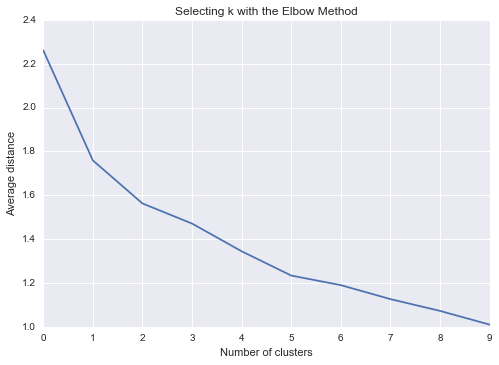

In [8]:
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method');

The elbow seems to be at 2 clusters in the figure above. But we will try the 3 clusters solution as it is a better case to use the canonical variables visualization.

## Interpret 3 clusters solution

In [9]:
model3=KMeans(n_clusters=3)
model3.fit(cluster_train)
clusassign=model3.predict(cluster_train)

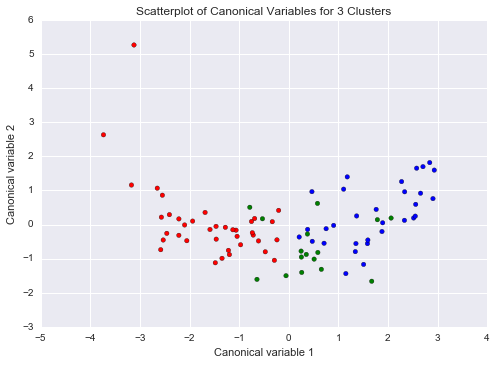

In [10]:
# plot clusters
color_map = {0 : 'r', 1 : 'b', 2 : 'g'}
def color(x):
    return color_map[x]
colors = list(map(color, model3.labels_))

from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(cluster_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=colors)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters');

From the evolution of the distance with the number of clusters, it was seen that 2 or 3 clusters seems the best division.
The visualization above of the three clusters (group 0 in red, 1 in blue and 2 in green) tends to favor a two clusters approach due to the overlapping of group 1 and 2.

In [11]:
new_clus = pd.Series(model3.labels_, 
                     index=cluster_train.index, 
                     name='cluster').to_frame()
                
new_clus.T

country,Portugal,Venezuela,Pakistan,"Yemen, Rep.",United Kingdom,China,Belgium,Greece,Sri Lanka,Tunisia,...,Philippines,Jamaica,Togo,Panama,Cambodia,Syria,Spain,Saudi Arabia,Libya,Turkey
cluster,0,2,1,2,0,1,0,0,1,2,...,1,1,1,0,1,2,0,2,2,2


In [12]:
merged_train = cluster_train.merge(new_clus, left_index=True, right_index=True)
merged_train.head()

,employrate,urbanrate,polityscore,lifeexpectancy,internetuserate,relectricperperson,cluster
country,,,,,,,
Portugal,-0.018263,-0.052379,0.894031,0.943017,0.480001,0.087743,0
Venezuela,0.231716,1.608206,-1.166919,0.352076,-0.085835,-0.092786,2
Pakistan,-0.735594,-1.195074,0.101358,-0.687316,-0.785168,-0.578992,1
"Yemen, Rep.",-2.039833,-1.465790,-1.008384,-0.680824,-0.947632,-0.614345,2
United Kingdom,0.166504,1.442442,0.894031,1.020812,1.706695,0.507101,0


In [13]:
counts = merged_train.cluster.value_counts()
counts.name = '# countries'
counts.index.name = 'cluster'
counts.sort_index().to_frame()

,# countries
cluster,
0,38
1,31
2,16


In [14]:
merged_train.groupby('cluster').mean()

,employrate,urbanrate,polityscore,lifeexpectancy,internetuserate,relectricperperson
cluster,,,,,,
0,-0.071462,0.653552,0.685433,0.740627,0.889400,0.453329
1,0.578111,-0.877530,-0.077633,-1.023464,-0.965004,-0.565492
2,-0.916286,-0.031046,-1.325454,0.045374,-0.387503,-0.243930


If we set *employment rate* aside, the group 0 gathers the *better* countries (high urban rate, democratic system, high life expectancy, high internet use rate and high electricity consumption) when the groups 1 and 2 gather the countries not having those characteristics.

The difference between the group 1 and 2 is mainly on the employment rate. The group 1 having a important employment rate when the group 2 has a low one.

## Validation on the test variable

The tree clusters will be tested against our test variable *income per person*. To confirm the accuracy of the clusters obtained.

In [15]:
target_train, target_test = train_test_split(target, 
                                             test_size=.3, 
                                             random_state=123)
merged_train_all=merged_train.merge(target_train.to_frame(), 
                                    left_index=True, 
                                    right_index=True)
sub1 = merged_train_all[[test_var, 'cluster']].dropna()

import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

income = smf.ols(formula='{} ~ C(cluster)'.format(test_var), data=sub1).fit()
income.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        incomeperperson   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     30.23
Date:                Sat, 13 Aug 2016   Prob (F-statistic):           1.46e-10
Time:                        18:31:35   Log-Likelihood:                -877.29
No. Observations:                  85   AIC:                             1761.
Df Residuals:                      82   BIC:                             1768.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept        1.452e+04   1213.543     11.962      0.000      1.21e+04  1.69e+04
C(cluster)[T.1] -1.326e+04   1810.501     -7.326      0.000     -1.69e+04 -9662.036
C(cluster)[T.2] -1.137e+04   2229.421     -5.098      0.000     -1.58e+04 -6931.247
==============================================================================
Omnibus:                       20.363   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.319
Skew:                           1.039   Prob(JB):                     4.30e-07
Kurtosis:                       4.990   Cond. No.                         3.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The ANOVA test confirms there is a significant variation of income per person with cluster (p-value = 1.46e-10 << 0.05). 

In [16]:
display(Markdown('means for income by cluster :'))
sub1.groupby('cluster').mean()

means for income by cluster :

,incomeperperson
cluster,
0,14516.002996
1,1252.303087
2,3149.728526


In [17]:
display(Markdown('standard deviations for income by cluster : '))
sub1.groupby('cluster').std()

standard deviations for income by cluster : 

,incomeperperson
cluster,
0,10958.920971
1,1233.242521
2,2577.331139


The group 0 has the highest income per person (even if we substract the standard deviation, it stays higher than the average of groups 1 and 2).

Group 1 has a lower average than group 2. But due to their respective standard deviation, they have a large overlapping confirming the idea of merging them for a better description.

In [18]:
mc1 = multi.MultiComparison(sub1[test_var], sub1['cluster'])
res1 = mc1.tukeyhsd()
res1.summary()

group1,group2,meandiff,lower,upper,reject
0,1,-13263.6999,-17585.4903,-8941.9096,True
0,2,-11366.2745,-16688.0541,-6044.4948,True
1,2,1897.4254,-3599.5005,7394.3514,False


The multiple comparison above confirms that the cluster analysis would be better keeping only two clusters as groups 1 and 2 have no significant difference.

## Validation on the test subset

The clustering will be validated on the test data set by looking at the evolution of the average distance with the number of clusters and by looking at the clusters in the canonical variables space.

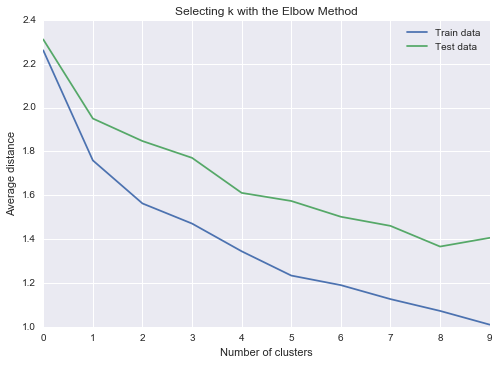

In [19]:
meandist_test = list()

for k in clusters:
    model = KMeans(n_clusters=k+1)
    model.fit(cluster_train)
    meandist_test.append(sum(np.min(cdist(cluster_test, 
                                     model.cluster_centers_, 
                                     'euclidean'),
                               axis=1))
                    / cluster_test.shape[0])
    
plt.plot(clusters, meandist, label='Train data')
plt.plot(clusters, meandist_test, label='Test data')
plt.legend()
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method');

The test data will be plotted in the canonical variables space using lighter colors to quickly visualize their dispersion compare to the training data.

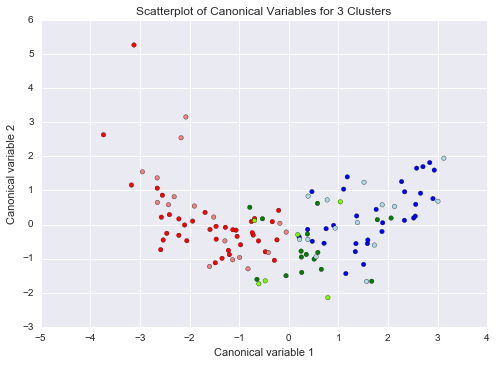

In [20]:
test_assign = model3.predict(cluster_test)
color_map = {0 : 'lightcoral', 1 : 'lightblue', 2 : 'lawngreen'}
def color(x):
    return color_map[x]
color_test = list(map(color, test_assign))

plot_col_test = pca_2.transform(cluster_test)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=colors)
plt.scatter(x=plot_col_test[:,0], y=plot_col_test[:,1], c=color_test)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters');

From the two figures above, the clustering in the training dataset seems to be confirmed by the test dataset. This confirms the clustering obtained on the training set.

## Conclusion

This assignment allows me to apply the unsupervised k-means cluster analysis on the Gapminder dataset. For the selected data, it seems that the countries are best described in a two clusters model; one have high quality of life (high urban rate, high life expectancy, high electricity consumption, high democratic system and high internet use rate) and the other one have lower quality of life. That cluster analysis was confirmed when testing for the income per person on the generated clusters.